In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import flopy as fp

# Use of Python in Groundwater Hydrology
# Session 1 - Groundwater Modelling

## Analytical solutions

### Confined aquifer (Theis)

The Theis solution is a famous formula in groundwater hydrology to compute the drawdown around a well in a confined aquifer. The aquifer is approximated as fully-confined and the transmissivity $T$ and storage coefficient $S$ are approximated as constant. The well extraction rate is $Q$.

The solution for a well that starts pumping at $t=0$ is
\begin{equation}\label{headtheis}
h = - \frac{Q}{4\pi T}\text{E}_1\left( u\right)
\end{equation}
where
\begin{equation}
u =  \frac{S r^2}{4Tt}
\end{equation}
and E$_1$ is the exponential integral
\begin{equation}
\text{E}_1(u) = \int_u^{\infty} \frac{\exp(-s)}{s}\text{d} s 
\end{equation}

Because the pumped water can only come from storage in the fully confined aquifer, the Theis solution does not reach steady state. It is only suitable to analyze the early stages of a pumping test, before other sources of water (i.e. from an overlying aquifer) start to contribute significantly to the well flow. 

The following example shows how the Theis solution is implemented in Python

In [2]:
# solution
from scipy.special import exp1

def theis(r, t, T, S, Q):
    u = S * r ** 2 / (4 * T * t)
    return -Q / (4 * np.pi * T) * exp1(u)

In [3]:
# parameters
k = 10 # hydraulic conductivity, m/d
H = 10 # aquifer thickness, m
T = k * H # transmissivity of aquifer, m^2/d
S = 0.001 # storage coefficient of aquifer, -
Q = 800 # discharge of well, m^3/d
rw = 0.3 # radius of well, m

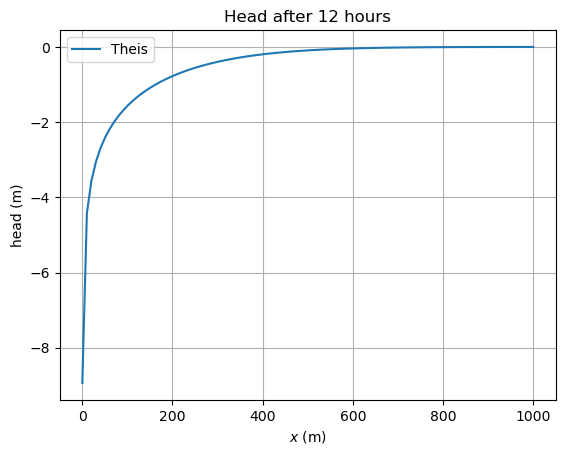

In [4]:
# basic plot for one value of r and one value of t
plt.subplot(111)
r = np.linspace(rw, 1000, 100)
t = 12 / 24
h = theis(r, t, T, S, Q)
plt.plot(r, h, label='Theis') # theis func from above
plt.title('Head after 12 hours')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('head (m)')
plt.legend();

### Semi-confined aquifer (Hantush)

For flow in a semi-confined aquifer, the pumpted groundwater initially comes from aquifer storage but as the heads drop around the well, water from the overlying aquifer (or surface water) will start to contribute.

<IMG src="merged_nbs6_81_0.png" width=400>

The solution to this problem (for the case that $h^*=0$) is referred to as the Hantush function
\begin{equation}\label{hhantush}
h = -\frac{Q}{4\pi T}\int_u^\infty \frac{1}{\tau}\exp\left(-\tau -\frac{r^2}{4\lambda^2 \tau}\right) \text{d}\tau
\end{equation}
where $\lambda=\sqrt{Tc}$ is the leakage factor, and $u$ is the same as in the Theis solution. Much has been written in the literature about how to solve the integral in the Hantush equation but in Python it can simply be calculated using the `quad` function of the `scipy.integrate` package.
    
The Hantush and Theis heads are very similar for early times when most of the water pumped by the well comes from storage. The Hantush and Theis heads deviate once a significant amount of water pumped by the well starts to come from leakage through the semi-confining layer.
    
The implementation of the Hantush solution in Python is as follows

In [5]:
# solution
from scipy.special import k0
from scipy.integrate import quad

def integrand(tau, r, T, lab):
    return 1 / tau * np.exp(-tau - r ** 2 / (4 * lab ** 2 * tau))

def hantush(r, t, T, S, c, Q):
    lab = np.sqrt(T * c)
    u = S * r ** 2 / (4 * T * t)
    F = quad(integrand, u, np.inf, args=(r, T, lab))[0]
    return -Q / (4 * np.pi * T) * F

hantushvec = np.vectorize(hantush) # vectorize hantush function

In [6]:
# Additional parameters
c = 1000 # hydraulic resistance of top aquitard, d
lab = np.sqrt(c * T) # leakage factor, m

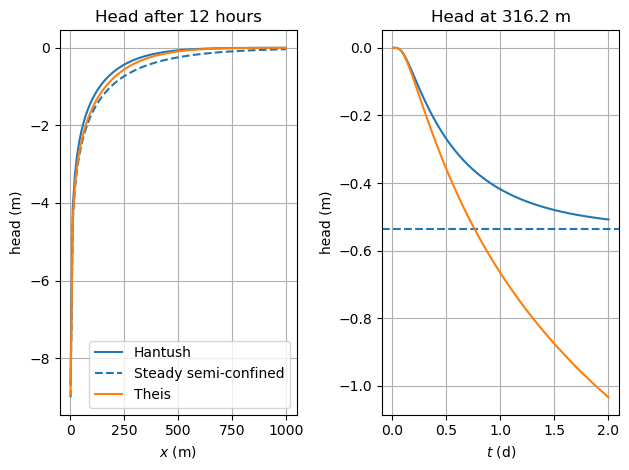

In [8]:
# basic plot for one value of r and one value of t
plt.subplot(121)
r = np.linspace(rw, 1000, 100)
t = 12 / 24
plt.plot(r, hantushvec(r, t, T, S, c, Q), label='Hantush')
plt.plot(r, -Q / (2 * np.pi * T) * k0(r / lab), 'C0--', label='Steady semi-confined')
plt.plot(r, theis(r, t, T, S, Q), label='Theis') # theis func from above
plt.title('Head after 12 hours')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('head (m)')
plt.legend()
plt.subplot(122)
t = np.linspace(0.01, 2, 100)
r = lab # evaluate head at r=lambda
plt.plot(t, hantushvec(r, t, T, S, c, Q), label='Hantush')
plt.axhline(-Q / (2 * np.pi * T) * k0(lab / lab), color='C0', ls='--', label='Steady semi-confined')
plt.plot(t, theis(r, t, T, S, Q), '-', label='Theis')
plt.title(f'Head at {lab:0.1f} m')
plt.grid()
plt.xlabel('$t$ (d)')
plt.ylabel('head (m)')
plt.tight_layout();

In addition to the Theis and Hantush solutions, the graphs above show the solution for steady flow to a well in a semi-confined aquifer (dashed blue line), which is
\begin{equation}\label{besselwell}
h = h^* -\frac{Q}{2\pi T} \text{K}_0(r/\lambda)
\end{equation}
in which K$_0$ is the modified Bessel function of the second kind and order 0.

## MODFLOW 6

Let's now try to model the Theis and Hantush solutions in MODFLOW 6, starting with the former. The first step in creating a MODFLOW 6 model is to create the simulation. 

In [9]:
modelname = 'model0' # model name to be used
modelws = './model0' # model work space to be used

sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='mf6.exe', # path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

For an accurate solution it is important to accurately resolve the earliest times after the pumping starts. This is achieved by using 20 irregular time steps by setting the time step multiplier to 1.2.

In [10]:
perlen = 0.5 # stress period length, d
nstp = 20 # number of time steps
tsmult = 1.2 # time step multiplier

tdis = fp.mf6.ModflowTdis(simulation=sim,
                          time_units='DAYS', 
                          nper=1,
                          perioddata=[(perlen, nstp, tsmult)],
                         )

The function `ModflowIms` defines the solver settings. There are many parameters that can be tweaked but for this exercise it is sufficient to select the default settings.

In [11]:
ims = fp.mf6.ModflowIms(sim)

### Groundwater flow model

Creating the groundwater flow model is done by calling the `ModflowGwf` function. The simulation to which the model belongs must always be specified.

In [12]:
gwf = fp.mf6.ModflowGwf(simulation=sim, 
                        modelname=modelname, # model name
                        save_flows=True # make sure all flows are stored in binary output file
                       )

A challenge in setting up the numerical model is to determine the extent of the model domain. The Theis function is for a semi-infinite aquifer, but in MODFLOW 6 we obviously have a finite model extent. As can be seen in the graph above, the head at $r = 1000$ m is almost unaffected by the well after a day of pumping. 
In the model below, we consider a simulation time of only 0.5 day. For that purpose, it is sufficient to extend the model 1000 m away from the well. We choose a model extent of 2040 m and start out with a cell size of 40 m, with the well placed in the central model cell.

In [13]:
# Model domain
Lx = 2040 # West-East length of domain, m
Ly = 2040 # North-South length of domain, m

# Well location
xwell = Lx / 2
ywell = Ly / 2

A grid of 51 rows and 51 columns is used, resulting in the desired cell size of 40 m in both the row and column directions. The top of the aquifer is at -20 meters, so the bottom is at -30 m.

In [14]:
# Layers
nlay = 1 # number of layers
top = -20 # top of top aquifer layer, m
botm = top - H # aquifer bottom, m

# Grid properties
ncol = 51 # number of columns
nrow = 51 # number of rows
delc = Ly / nrow # cell size in column direction
delr = Lx / ncol # cell size in row direction

dis = fp.mf6.ModflowGwfdis(model=gwf, 
                           length_units='METERS', 
                           nlay=nlay, 
                           nrow=nrow, 
                           ncol=ncol,
                           delr=delr, 
                           delc=delc, 
                           top=top, 
                           botm=botm, 
                          ) 

Aquifer properties are defined with the `ModflowGwfnpf` function.

In [15]:
npf = fp.mf6.ModflowGwfnpf(model=gwf, 
                           save_specific_discharge=True, # save the specific discharge for every cell
                           k=k, # horizontal k value
                          )

The storage package is invoked to simulate transient flow. Note how the storage coefficient is divided by the aquifer thickness because it is the specific storage coefficient that must be passed to `ModflowGwfsto`.

In [16]:
sto = fp.mf6.ModflowGwfsto(model=gwf, 
                           ss=S / H, 
                           transient=True,
                          )

The function `ModflowGwfic` sets the intial conditions. Initially all heads are zero.

In [17]:
ic = fp.mf6.ModflowGwfic(model=gwf, 
                         strt=0, # initial head,
                        )

The row and column numbers of the center cell (where the well is located) are found by dividing `nrow` and `ncol` by two. The two forward slashes indicate an integer division in Python, which ensures that the result of the division is also an integer number.

In [18]:
rwell = nrow // 2 # results in an integer
cwell = ncol // 2
spd_list = [[(0, rwell, cwell), -Q]]
well_spd = {0: spd_list} # dictionary of stress period data

wel = fp.mf6.ModflowGwfwel(model=gwf, 
                           stress_period_data=well_spd,
                           pname='wells' # package name
                          )

Output control is specified using `ModflowGwfoc`.

In [19]:
oc = fp.mf6.ModflowGwfoc(model=gwf, # add output control to model gwf (created in previous code cell)
                         budget_filerecord=f"{modelname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{modelname}.hds", # file name where all head output is stored
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
                        )

### Visually check input

Before running the model it is worthwhile to inspect the grid and make sure that the well is indeed in the correct location.

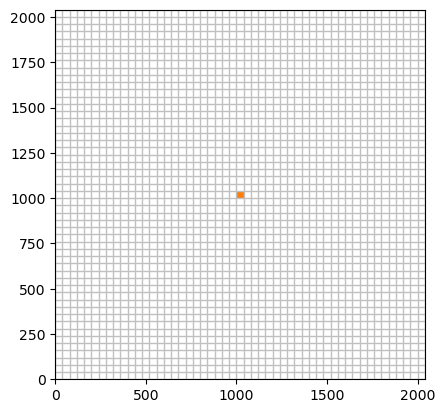

In [20]:
pmv = fp.plot.PlotMapView(model=gwf, layer=0) # create view of layer 0
pmv.plot_bc(name='wells', color='C1') # add 'wells' cells
pmv.plot_grid(colors='silver', lw=1); # add grid

We write the input files and run the model with the `silent` option set to `True` to reduce the amount of screen output.

In [21]:
sim.write_simulation(silent=False)
success, _ = sim.run_simulation(silent=True) 
if success == True:
    print('Model solved successfully')
else:
    print('Solve failed')

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model model0...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package wells...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
Model solved successfully


Once the results are calculated we can read the binary head file and plot the head contours at the end of the simulation.

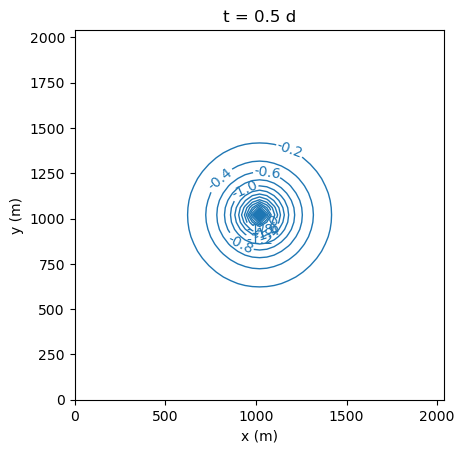

In [22]:
hds = gwf.output.head() # get handle to binary head file
times = hds.get_times()
head = hds.get_data(totim=times[-1])
pmv = fp.plot.PlotMapView(model=gwf, layer=0)
pmv.plot_bc('wells', color='C1')
cs = pmv.contour_array(head, levels=np.arange(-5, 0.5, 0.2), linewidths=1, colors='C0', linestyles='-') # contour plot of heads
plt.clabel(cs, fmt='%1.1f'); # add contour labels with one decimal place
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f't = {times[-1]} d');

### Comparison with analytical solution
In order the compare the numerical results with the analytic solution, the heads from the MODFLOW model are plotted as a function of $r$ for a subset of all the time steps in the model. The lines are drawn as step plots to emphasize that this is the result from the numerical (discretized) model. For each time step, the analytic solution is plotted as well. In the right graph, the head is plotted versus time for the first cell next to the well.

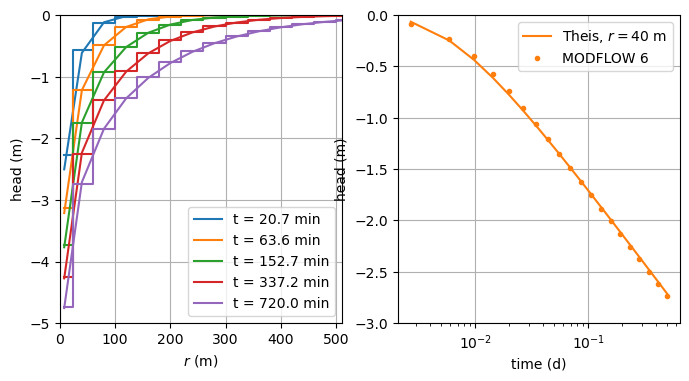

In [23]:
# basic plot for one value of r and one value of t
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

ax = axs[0]
times = np.array(hds.get_times())
r = np.arange(0, Lx / 2, delr)
r[0] = delr / 5
for i, t in enumerate(times[3::4]):
    # Numerical solution
    head = hds.get_data(totim=t, mflay=0)
    ax.step(r, head[rwell, cwell:], where='mid', color='C' + str(i), label=f't = {t * 1440:0.1f} min')
    # Analytic solution
    ax.plot(r, theis(r, t, T, S, Q), color='C' + str(i))
    
ax.grid()
ax.legend()
ax.set_xlabel('$r$ (m)')
ax.set_ylabel('head (m)')
ax.set_xlim(0, Lx / 4)
ax.set_ylim(-5, 0)

ax = axs[1]
ax.semilogx(times, theis(delr, times, T, S, Q), 'C1', label='Theis, $r=40$ m')
ht = hds.get_ts([[0, rwell + 1, cwell]])
ax.semilogx(ht[:, 0], ht[:, 1], 'C1.', label='MODFLOW 6')


ax.grid()
ax.legend()
ax.set_xlabel('time (d)')
ax.set_ylabel('head (m)')
ax.set_ylim(-3, 0);

## Create semi-confined model

In the previous model, the top model boundary was simulated as impermeable (impermeable is the default of any MODFLOW boundary), which represents a fully confined aquifer. Here, the model is modified so simulate flow in a semi-confined aquifer. A GHB boundary is specified for all cells to simulate semi-confined conditions. The model is  very similar to the previous model, except for the addition of the GHB package.

The GHB package is added by looping over all cells in the model. The conductance is the surface area of a cell divided by the hydraulic resistance of the aquitard ($C = A / c$). The surface area is calculated using the cell dimensions `delr` and `delc`.

In [24]:
A = delr * delc
C = A / c

spd_list = []
for row in range(nrow):
    for col in range(ncol):
        spd_list.append([(0, row, col), 0, C])

ghb = fp.mf6.ModflowGwfghb(model=gwf, 
                           stress_period_data={0: spd_list},
                           pname='ghb'
                          )

We rerun the model

In [25]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


And plot the results

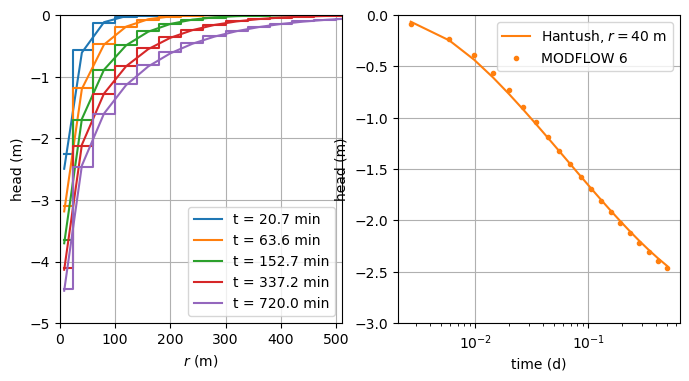

In [26]:
# basic plot for one value of r and one value of t
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

ax = axs[0]
times = np.array(hds.get_times())
r = np.arange(0, Lx / 2, delr)
r[0] = delr / 5
for i, t in enumerate(times[3::4]):
    # Numerical solution
    head = hds.get_data(totim=t, mflay=0)
    ax.step(r, head[rwell, cwell:], where='mid', color='C' + str(i), label=f't = {t * 1440:0.1f} min')
    # Analytic solution
    ax.plot(r, hantushvec(r, t, T, S, c, Q), color='C' + str(i))
    
ax.grid()
ax.legend()
ax.set_xlabel('$r$ (m)')
ax.set_ylabel('head (m)')
ax.set_xlim(0, Lx / 4)
ax.set_ylim(-5, 0)

ax = axs[1]
ax.semilogx(times, hantushvec(delr, times, T, S, c, Q), 'C1', label='Hantush, $r=40$ m')
ht = hds.get_ts([[0, rwell + 1, cwell]])
ax.semilogx(ht[:, 0], ht[:, 1], 'C1.', label='MODFLOW 6')

ax.grid()
ax.legend()
ax.set_xlabel('time (d)')
ax.set_ylabel('head (m)')
ax.set_ylim(-3, 0);

This example is a simplified version of a more extensive version in the online course that will be organised by the Australian Water School in September 2023. For more details see <A href="https://awschool.com.au/training/modflow6-flopy/">https://awschool.com.au/training/modflow6-flopy/</A>.

This notebook was presented by Vincent Post on 8 June 2023 as part of the two-session webinar series titled "Use of Python in Groundwater Hydrology", organised by the International Association of Hydrogeologists (IAH) Lebanon Chapter in collaboration with the Department of Geology at the American University of Beirut.